<a href="https://colab.research.google.com/github/hidircan/IstDsa/blob/main/Metro_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Proje 1: Keşifsel Veri Analizi (EDA) METRO_PROJECT**





Karrine ve Dahlia'nın isteği, MTA turnike verileri kullanarak sokak ekiplerinin yerleşimini optimize etmektir. Bu, potansiyel olarak en fazla kişiye ulaşmak için sokak ekiplerinin en verimli bir şekilde konumlandırılmasını gerektirir.

Bu sorunu çözmek için, veri setindeki her istasyonun ortalama günlük giriş çıkış sayısını hesaplamak ve ardından sokak ekiplerini bu istasyonlara en çok talep olan saatlerde yerleştirmek iyi bir yaklaşım olabilir.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_220528.txt')
data.rename(columns={"EXITS                                                               ": "EXITS"}, inplace=True)

In [ ]:
# Tarih ve saat sütunlarını birleştirip yeni bir gün sütunu oluşturulur:
data["DATETIME"] = pd.to_datetime(data["DATE"] + " " + data["TIME"], format="%m/%d/%Y %H:%M:%S")
data["DAY"] = data["DATETIME"].dt.date

In [ ]:
# Her istasyonun ortalama günlük giriş çıkış sayısını hesaplayalim
data.ENTRIES = data.ENTRIES/100000
data.EXITS = data.EXITS/100000
station_totals = (data.groupby(["STATION", "DAY"])
                  .agg({"ENTRIES": "first", "EXITS": "first"})
                  .diff().fillna(0)
                  .groupby("STATION")
                  .mean()
                  .sort_values(by="ENTRIES", ascending=False))

print(station_totals.head())


                   ENTRIES        EXITS
STATION                                
HEWES ST       3067.445131   958.880823
DEKALB AV      2855.024916  2643.657780
183 ST         2524.679499  2656.177170
72 ST-2 AVE    2331.602247  2754.155924
PROSPECT PARK  2222.980231  1117.652609


In [ ]:
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,00:00:00,REGULAR,77.14568,27.06545,2022-05-21 00:00:00,2022-05-21
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,04:00:00,REGULAR,77.14583,27.06554,2022-05-21 04:00:00,2022-05-21
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,08:00:00,REGULAR,77.14590,27.06575,2022-05-21 08:00:00,2022-05-21
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,12:00:00,REGULAR,77.14641,27.06648,2022-05-21 12:00:00,2022-05-21
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,16:00:00,REGULAR,77.14728,27.06690,2022-05-21 16:00:00,2022-05-21


In [ ]:
# Sokak ekiplerinin konumlandırılması için en iyi saatleri hesaplayalim
best_hours = (data.groupby(["STATION", "DAY", data["DATETIME"].dt.hour])
              .agg({"ENTRIES": "first", "EXITS": "first"})
              .diff().fillna(0)
              .groupby(["STATION", "DAY"])
              .sum()
              .idxmax(axis=1)
              .reset_index()
              .rename(columns={0: "BEST_HOUR"}))

print(best_hours.head(30))

          STATION         DAY BEST_HOUR
0            1 AV  2022-05-21     EXITS
1            1 AV  2022-05-22     EXITS
2            1 AV  2022-05-23     EXITS
3            1 AV  2022-05-24     EXITS
4            1 AV  2022-05-25     EXITS
5            1 AV  2022-05-26     EXITS
6            1 AV  2022-05-27     EXITS
7          103 ST  2022-05-21   ENTRIES
8          103 ST  2022-05-22     EXITS
9          103 ST  2022-05-23     EXITS
10         103 ST  2022-05-24     EXITS
11         103 ST  2022-05-25     EXITS
12         103 ST  2022-05-26   ENTRIES
13         103 ST  2022-05-27   ENTRIES
14  103 ST-CORONA  2022-05-21     EXITS
15  103 ST-CORONA  2022-05-22     EXITS
16  103 ST-CORONA  2022-05-23     EXITS
17  103 ST-CORONA  2022-05-24     EXITS
18  103 ST-CORONA  2022-05-25     EXITS
19  103 ST-CORONA  2022-05-26     EXITS
20  103 ST-CORONA  2022-05-27     EXITS
21         104 ST  2022-05-21   ENTRIES
22         104 ST  2022-05-22     EXITS
23         104 ST  2022-05-23   ENTRIES


Bu kod, her bir turnike cihazının her tarih ve saat için giriş ve çıkış sayılarını hesaplar ve sonra her istasyon için ortalama günlük giriş ve çıkış sayısını hesaplar. Ardından, istasyonları en yüksek ortalama günlük giriş sayısına göre sıralar ve ilk beş istasyonu ekrana yazdırır.

Daha sonra, sokak ekiplerinin konumlandırılması için en iyi saatleri hesaplamak için, her istasyonun her gün için saatlere göre giriş ve çıkış sayılarını toplar ve ardından her gün için en yüksek toplam giriş sayısına sahip saatleri seçer. Bu saatleri BEST_HOUR sütununda saklar ve ilk beş sonucu ekrana yazdırır.


In [ ]:
# Her istasyonun günlük toplam yolcu sayısını hesaplayalım
station_totals = data.groupby(["STATION", "DATE"]).agg({"ENTRIES": "first", "EXITS": "first"}).diff().fillna(0).reset_index()
station_totals["TOTAL"] = station_totals["ENTRIES"] + station_totals["EXITS"]


Daha sonra top_stations dataframe'inde "TOTAL" sütunu kullanılarak grafik oluşturulabilir. Tam kod aşağıdaki gibi olacaktır:

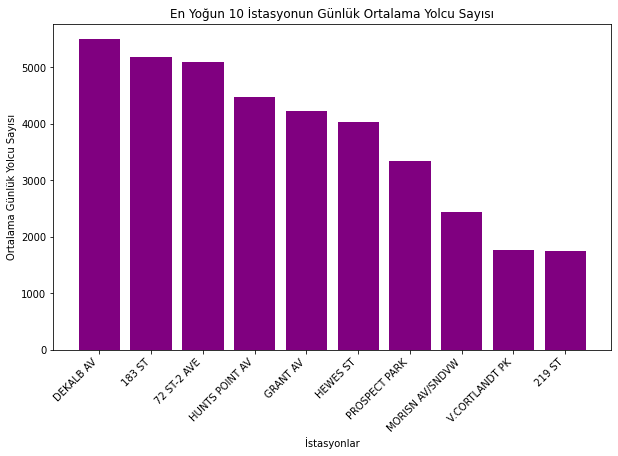

In [ ]:
# Her istasyonun günlük toplam yolcu sayısını hesaplayalım
station_totals = data.groupby(["STATION", "DATE"]).agg({"ENTRIES": "first", "EXITS": "first"}).diff().fillna(0).reset_index()
station_totals["TOTAL"] = station_totals["ENTRIES"] + station_totals["EXITS"]

# En yoğun 10 istasyonun günlük ortalama giriş-çıkış sayılarını alalım
top_stations = station_totals.groupby('STATION').mean().sort_values(by='TOTAL', ascending=False).head(10)

# Grafik boyutlarını ayarlayalım
plt.figure(figsize=(10,6))

# Grafik çizdirelim
plt.bar(top_stations.index, top_stations["TOTAL"], color='purple')

# Eksen isimlerini ve başlığı ayarlayalım
plt.xlabel("İstasyonlar")
plt.ylabel("Ortalama Günlük Yolcu Sayısı")
plt.title("En Yoğun 10 İstasyonun Günlük Ortalama Yolcu Sayısı")
plt.xticks(rotation=45, ha='right')

# Grafiği gösterelim
plt.show()

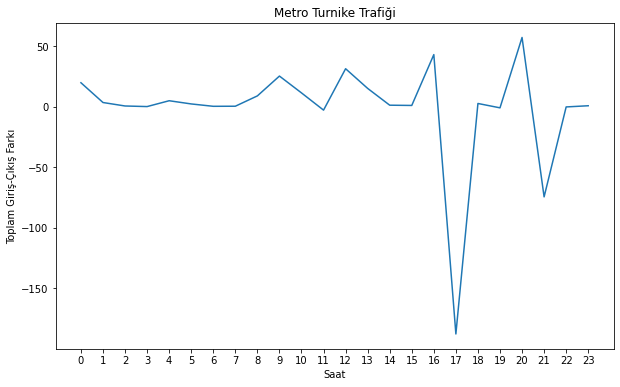

In [ ]:
# İstasyon turnikeleri arasındaki giriş-çıkış farkını hesapla
data["ENTRIES_DIFF"] = data.groupby(["C/A", "UNIT", "SCP", "STATION"])["ENTRIES"].diff()
data["EXITS_DIFF"] = data.groupby(["C/A", "UNIT", "SCP", "STATION"])["EXITS"].diff()

# NaN değerleri 0 ile değiştir
data.fillna(0, inplace=True)

# Toplam giriş-çıkış farkını hesapla
data["TRAFFIC"] = data["ENTRIES_DIFF"] + data["EXITS_DIFF"]

# Saatleri ayır
data["HOUR"] = data["DATE_TIME"].dt.hour

# Her saatteki toplam giriş-çıkış farkını hesapla
hourly_traffic = data.groupby("HOUR")["TRAFFIC"].sum()

# Grafik oluştur
plt.figure(figsize=(10,6))
plt.plot(hourly_traffic)
plt.xlabel("Saat")
plt.ylabel("Toplam Giriş-Çıkış Farkı")
plt.title("Metro Turnike Trafiği")
plt.xticks(range(0, 24))
plt.show()

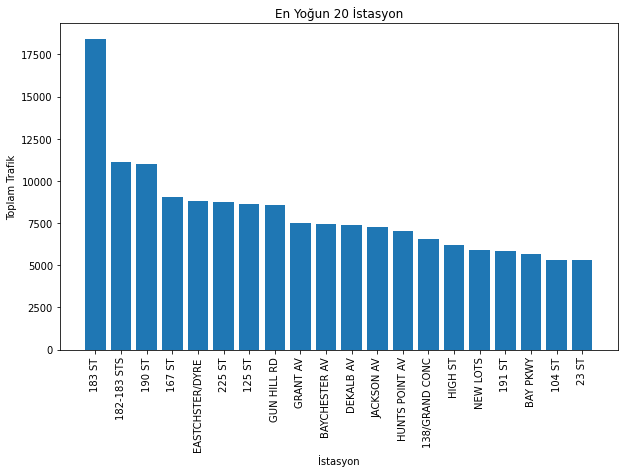

In [ ]:
# Group by station and compute mean entries and exits
station_stats = data.groupby(["STATION", "LINENAME"])[["ENTRIES", "EXITS"]].mean().reset_index()

# Calculate total traffic by adding entries and exits
station_stats["TRAFFIC"] = station_stats["ENTRIES"] + station_stats["EXITS"]

# Sort by traffic to find busiest stations
busiest_stations = station_stats.sort_values("TRAFFIC", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(busiest_stations["STATION"][:20], busiest_stations["TRAFFIC"][:20])
plt.xticks(rotation=90)
plt.title("En Yoğun 20 İstasyon")
plt.xlabel("İstasyon")
plt.ylabel("Toplam Trafik")
plt.show()